# CE7454 Project - Group 01
# Sleep stages classification using EEG signals
### Emadeldeen Ahmed, Lotfi Ismail, Rakaraddi Appan

The link to our GitHub repository is [here](https://github.com/ismail0T/CE7454_project).


# Part I: Motivation
Sleep-wake classification is important for measuring the sleep quality as it significantly affects the quality of daily life and it helps in finding out sleep disorders. A lot of studies have been made in this field but most of them used hand-crafted features extraction which may lead to less accurate classification results and longer processing time. However, some new deep learning models can also be deployed to achieve better accuracy and faster results.

# Part II: Dataset Exploration
We will start by exploring and exploiting a public sleep EEG dataset, Physionet, which can be downloaded from [Physionet website](https://physionet.org/physiobank/database/sleep-edfx/). The dataset contains 78 whole-night PSG data and the corresponding hypnograms (sleep patterns).

PSG recordings include Electroencephalogram (EEG), Electrooculogram (EOG), Electromyogram (EMG) and Electrocardiogram (ECG) recordings [[1]](https://www.sciencedirect.com/science/article/pii/S0925231212008387). These PSG data can be classified as wake(W), Rapid Eye Movement (REM) sleep and Non-REM. Non-REM sleep is further divided into stages 1, 2, 3 and 4 [[2]](https://www.ncbi.nlm.nih.gov/pubmed/25629798). As indicated in the literature, the EEG are the most important and frequently used signals for analyzing sleep staging and many researches uses single-channel EEG to help reducing the sleep disturbances caused by PSG recording equipment.
In this analysis, we will explore using the same channel mentioned in the literature as well as using another channel besides. 
Note that we have tried using EOG recordings instead of EEG but didn't achieve better results.

In [10]:
import os
import random
import warnings
warnings.filterwarnings('ignore')
import datetime
import ntpath
from itertools import chain, repeat
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import mne
from mne.io import read_raw_edf
from mne import viz

from bokeh.io import output_notebook
output_notebook()

import torch
import torch.nn as nn
import torch.nn.functional as F

from Utils import *
from NN_Utils import *

Loading BokehJS ...

In [3]:
ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}
# Label values
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

sampling_rate = 100.0
EPOCH_SEC_SIZE = 30

In [25]:
data_path = '/home/ismail/Dev/data_2013'
# single subject
data_files = os.listdir(data_path)

edf_data_files = [i for i in data_files if "-PSG" in i]
hyp_data_files = [i for i in data_files if "Hypnogram" in i]

edf_files_path = os.path.join(data_path, edf_data_files[10])
hyp_files_path = os.path.join(data_path, hyp_data_files[10])

print(f"Number of PSG files used in analysis:       {len(edf_data_files)} files")
print(f"Number of hypnogram files used in analysis: {len(hyp_data_files)} files")

Number of PSG files used in analysis:       39 files
Number of hypnogram files used in analysis: 39 files


In [12]:
class_duration = {0:0,1:0,2:0,3:0,4:0}

for i in range(len(edf_data_files)):
#     psg_files_path = os.path.join(data_path, edf_data_files[i])
    hyp_files_path = os.path.join(data_path, hyp_data_files[i])
    
    # Read annotation and its header
    f = open(hyp_files_path, 'r', errors='ignore')
    reader_ann = BaseEDFReader(f)
    reader_ann.read_header()
    h_ann = reader_ann.header
    _, _, ann = zip(*reader_ann.records())
    f.close()
    ann_start_dt = datetime.datetime.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

    file_duration_in_sec = ann[0][len(ann[0])-1][0] + ann[0][len(ann[0])-1][1]
    
    # Generate label and remove indices
    count = 0
    for a in ann[0]:
        onset_sec, duration_sec, ann_char = a
        ann_str = ann_char[0][2:-1]
        label = ann2label[ann_str]
        if label != UNKNOWN:
            if duration_sec % EPOCH_SEC_SIZE != 0:
                raise Exception("Something wrong")
            class_duration[label] += duration_sec
            count+=1


In [20]:
x = class_duration
import math
from bokeh.io import output_file, show
from bokeh.palettes import Category20c
from bokeh.palettes import Spectral6
from bokeh.plotting import figure
from bokeh.transform import cumsum
import pandas as pd
data = pd.Series(x).reset_index(name='value').rename(columns={'index':'class'})
data['angle'] = data['value']/data['value'].sum() * 2*math.pi
data['color'] = Category20c[len(x)]

p = figure(plot_height=350, title="Pie Chart", toolbar_location=None,
        tools="hover", tooltips="@class: @value")

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='Class', source=data)
show(p)

In [27]:
raw = read_raw_edf(edf_files_path, preload=True, stim_channel=None, verbose=False)

from bokeh.layouts import gridplot
from bokeh.plotting import figure

# Extract data from the first 5 channels, from 1 s to 3 s.
sfreq = raw.info['sfreq']

data = {}
times = {}
ch_names = {}
for ch in range(len(raw.info["chs"])): # 7 channels
    ch_names[ch] = raw.info["chs"][ch]['ch_name']
    data[ch], times[ch] = raw[ch, int(sfreq * 1):int(sfreq * 10)]

#data_1, times_1 = raw[1, int(sfreq * 1):int(sfreq * 10)]

# for i in range(len(raw.info["chs"])):
#     fig = plt.subplots(figsize=(10,8))
#     plt.plot(times[i], data[i].T)
#     plt.xlabel('Seconds')
#     plt.ylabel('$\mu V$')
#     plt.legend([ch_names[i]])
#     plt.show()


# create three plots
ss = []
for i in range(7):
    s = figure()
    s.line(times[i], data[i].squeeze(), color='navy', alpha=0.5, legend=[ch_names[i]])
    ss.append(s)
    
# s2 = figure()
# s2.line(times[1], data[1].squeeze(), color='navy', alpha=0.5, legend=[ch_names[1]])
# s3 = figure()
# s3.line(times[2], data[2].squeeze(), color='navy', alpha=0.5, legend=[ch_names[2]])
# make a grid
grid = gridplot(ss, ncols=1, plot_width=900, plot_height=250)

# show the results
show(grid)

# Part III: Dataset Preprocessing


In [ ]:
# %run -i 'prepare_physionet.py' 

In [3]:
# import


data_dir_eeg = "../data_2013/traindata_eeg"
classes = ['W', 'N1', 'N2', 'N3', 'REM']
n_classes = len(classes)
device = torch.device("cuda:0")
num_folds = 20

# 1. MLP

In [10]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.n_classes = 5

        self.layer1 = nn.Linear(3000, 256, bias=False)
        self.layer2 = nn.Linear(256, self.n_classes, bias=False)

    def forward(self, x):
        x = x.reshape(x.size(0), x.size(1) * x.size(2))

        y = self.layer1(x)
        y = F.relu(y)

        scores = self.layer2(y)

        return  scores


In [11]:
def run_experiment_cross_validation_MLP():
    MyNNutils = NN_Utils(learning_rate, batch_size, num_epochs)
    train_history_over_CV = []
    val_history_over_CV = []
    confusion_matrix_train_CV = []
    confusion_matrix_test_CV = []

    print('num_folds: ', num_folds, ' num_epochs: ', num_epochs)


    for fold_id in range(0, num_folds):
        # Loading Data
        X_train, y_train, X_test, y_test = prep_train_validate_data_CV(data_dir_eeg, fold_id, batch_size)

        if fold_id == 0:
            print('Train Data Shape: ', X_train.shape, '  Test Data Shape: ', X_test.shape)
            print('\n')

        char2numY = dict(zip(classes, range(len(classes))))
        for cl in classes:
            print("__Train ", cl, len(np.where(y_train == char2numY[cl])[0]), " => ",
                  len(np.where(y_test == char2numY[cl])[0]))

        print("\nFold <" + str(fold_id + 1) + ">")

        # model #
        net = MLP()
        if fold_id == 0:
            display_num_param(net)
        net = net.to(device)

        train_history, validation_history, confusion_matrix_train_list, confusion_matrix_test_list = MyNNutils.train_model_cnn(net, X_train, y_train, X_test, y_test, device)
        
        # accumulate history for each CV loop, then take average
        train_history_over_CV.append(train_history)
        val_history_over_CV.append(validation_history)
        confusion_matrix_train_CV.append(confusion_matrix_train_list)
        confusion_matrix_test_CV.append(confusion_matrix_test_list)

        del net

    print(train_history_over_CV)
    print(val_history_over_CV)

    confusion_matrix_test_CV_final = confusion_matrix_test_CV[0]
    for i in range(1, num_folds):
        confusion_matrix_test_CV_final += confusion_matrix_test_CV[i]

    best_epoch_id = np.argmax(np.asarray(np.matrix(val_history_over_CV).mean(0)).reshape(-1))

    confusion_matrix_test_best = confusion_matrix_test_CV_final[best_epoch_id]
        
    return train_history_over_CV, val_history_over_CV, confusion_matrix_test_best

    

In [5]:
num_epochs = 30
batch_size = 128
learning_rate = 0.001

train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation_MLP()

# train_history_over_CV = [[29.91325369738339, 29.95413822525597, 29.95413822525597, 35.42910978384528, 41.823094425483504, 43.947312286689424, 46.40749431171786, 52.58105802047781, 55.563850967007966, 58.90216154721274, 64.36468998862344, 68.40692548350398, 69.99608930602957, 71.48215301478953, 72.6500284414107, 73.84456769055745, 74.76358077360638, 75.44439704209329, 75.86924061433447, 76.9073521046644, 77.19532138794084, 77.55261660978384, 77.73570819112628, 77.90280147895335, 78.11077929465301], [30.148446573751453, 30.153890824622533, 30.153890824622533, 32.49673344947735, 40.58507549361208, 49.77497096399535, 53.11048199767712, 59.03745644599303, 64.61055458768872, 67.58855981416957, 68.6175232288037, 69.47408536585365, 70.1346544715447, 70.7171893147503, 71.23257839721255, 71.70622822299651, 72.19439605110337, 72.67349012775843, 72.94025842044135, 74.01277584204414, 74.23780487804879, 74.57171893147503, 74.86933797909407, 75.03629500580719, 75.29398954703834], [29.588541666666668, 29.72222222222222, 29.72222222222222, 30.095486111111114, 38.46527777777778, 47.13541666666667, 52.270833333333336, 55.96180555555556, 63.432291666666664, 67.61631944444444, 68.40277777777779, 69.12326388888889, 70.11111111111111, 70.75520833333333, 71.62673611111111, 72.34375, 73.31423611111111, 74.12673611111111, 75.03125, 75.97569444444444, 76.66840277777777, 77.02256944444444, 77.02777777777777, 77.50347222222223, 77.97222222222221], [29.814332018038332, 29.86541713641488, 29.86541713641488, 30.05918827508455, 39.953847237880495, 43.330749718151075, 45.46751691093574, 52.32877677564826, 54.69278466741826, 58.36386696730552, 63.61682638105975, 67.31257046223224, 68.98604847801579, 70.03945885005636, 71.01007609921083, 72.0934329199549, 72.96364148816235, 73.81447294250282, 74.7075817361894, 75.73809188275085, 75.92305524239008, 76.09921082299887, 76.5625, 76.74922491544532, 77.11386696730553], [29.63894284128746, 29.708310210876803, 29.708310210876803, 29.739525527192008, 37.56069644839068, 43.66849334073252, 50.228912319644834, 56.98009156492786, 65.44811320754717, 69.22863485016649, 70.11306881243064, 71.55070754716981, 72.51317980022198, 73.31957547169812, 74.2733768035516, 75.09538013318536, 75.70754716981132, 76.2017896781354, 76.57637347391787, 77.31687014428414, 77.54578246392897, 77.86660654827969, 77.90996115427303, 77.85966981132076, 78.56028024417314], [29.6664088863892, 29.83689538807649, 31.489032620922387, 42.125984251968504, 50.0562429696288, 52.71899606299213, 57.824803149606296, 64.55989876265467, 67.35447131608548, 69.85376827896513, 70.73959505061868, 71.9382733408324, 72.53761248593926, 73.4867125984252, 74.16162823397076, 75.0755764904387, 75.40424634420697, 76.29710348706412, 76.43771091113611, 77.18820303712036, 77.44129640044994, 77.55378233970754, 77.64341957255343, 78.0845753655793, 78.0248172103487], [29.713834269662918, 29.834971910112362, 29.926264044943817, 37.42801966292134, 47.13658707865169, 51.502808988764045, 53.54634831460674, 57.2875702247191, 64.54002808988764, 68.14782303370787, 69.09761235955057, 70.19136235955055, 71.25351123595506, 71.15695224719101, 72.2068117977528, 72.74754213483146, 73.33567415730336, 73.94136235955057, 74.70505617977527, 75.25456460674157, 75.63026685393258, 76.08321629213484, 76.01123595505618, 76.51509831460675, 76.73455056179776], [29.614175977653634, 29.767807262569836, 29.767807262569836, 32.309706703910614, 41.70391061452514, 49.70670391061452, 52.41445530726258, 58.015013966480446, 63.91236033519553, 67.35335195530726, 68.42004189944134, 69.6002094972067, 69.91445530726257, 71.10858938547486, 71.7213687150838, 72.24860335195531, 72.56284916201118, 72.98358938547486, 73.45495810055866, 74.15153631284916, 74.66305865921787, 74.79923184357543, 75.32122905027933, 75.48009776536313, 75.98812849162012], [29.64555369127517, 29.778383668903803, 29.778383668903803, 30.991331096196866, 39.41729586129754, 47.76286353467562, 51.97497203579419, 54.664779082774054, 61.75720078299777, 66.71210850111858, 67.94428131991052, 68.73252237136465, 69.47182606263982, 70.09752516778524, 70.71798098434004, 71.53243847874721, 72.19484060402685, 73.57557326621924, 74.11563199105146, 75.51034675615213, 75.74454697986577, 76.13255033557047, 76.6935822147651, 76.87884507829978, 77.10780201342283], [29.61144911504425, 29.6788578539823, 29.6788578539823, 29.6788578539823, 36.86739491150443, 42.906526548672566, 45.388550884955755, 52.40078816371682, 55.555171460176986, 61.08441648230089, 66.25069137168141, 68.65839325221239, 70.09126106194691, 71.45672013274337, 72.14117809734513, 73.43404314159292, 74.23257743362832, 75.20568307522124, 76.08718196902655, 77.17436393805309, 77.21584623893806, 77.49239491150442, 77.83980918141593, 78.03166482300885, 78.2511753318584], [29.494112814895946, 29.569414019715225, 29.569414019715225, 29.569414019715225, 37.34255202628697, 45.06948247535597, 51.4683734939759, 54.10049288061336, 60.24609802847755, 67.07112541073384, 68.54634446878423, 69.54408543263965, 70.25944687842278, 71.411213033954, 72.58522727272727, 73.86877053669222, 74.84255202628697, 75.64690580503833, 76.2287787513691, 77.18544633077765, 77.69201807228916, 77.92305585980284, 77.99664567360351, 78.22426067907996, 78.48439211391019], [29.93636234357224, 29.95413822525597, 29.95413822525597, 32.442761660978384, 41.019624573378834, 49.31029579067122, 52.469069965870304, 54.25199089874858, 58.78306313993175, 66.13694539249147, 67.92697667804323, 68.86021046643913, 69.89654436860067, 70.98442832764505, 71.69190841865756, 72.86511660978384, 73.80012798634812, 74.22319397042094, 75.05688282138794, 76.02922354948805, 76.1856513083049, 76.4362912400455, 76.61227246871445, 77.16154721274175, 77.22731797497156], [29.84251691093574, 29.854847801578355, 29.854847801578355, 29.854847801578355, 32.75789177001127, 40.58448421645998, 49.17383032694475, 52.56482525366404, 56.04389797068771, 64.48879650507328, 66.11823562570463, 67.45349492671929, 68.70243799323562, 69.67833990980834, 71.0576381059752, 72.17446448703495, 73.33709131905299, 73.84089627959413, 74.98414599774522, 75.62182919954904, 76.04284103720406, 76.46561443066517, 76.88662626832019, 77.00817361894025, 77.11562852311161], [29.666550279329606, 29.760824022346366, 29.771298882681563, 38.21752793296089, 43.75872905027933, 51.08763966480447, 53.85300279329609, 55.645949720670394, 60.951466480446925, 67.1002094972067, 68.78840782122904, 69.42912011173185, 70.11522346368714, 70.84148044692738, 72.03561452513966, 73.11103351955308, 73.97346368715084, 75.1483938547486, 75.53072625698324, 76.53980446927375, 76.73184357541899, 77.09497206703911, 77.22590782122904, 77.54189944134077, 77.79678770949721], [29.87309106334842, 29.888998868778284, 29.888998868778284, 31.794400452488684, 40.921945701357465, 49.163956447963805, 52.209417420814475, 54.542562217194565, 60.23755656108597, 66.07925622171946, 67.41904694570135, 68.57324660633483, 69.47822398190046, 70.44506504524887, 71.13086821266968, 71.95453902714932, 72.50600961538461, 73.1193438914027, 73.87408088235294, 74.63412047511312, 75.45425622171946, 75.51788744343891, 75.78125, 76.01633201357465, 76.31327771493213], [29.697974860335197, 29.7643156424581, 29.7643156424581, 33.30831005586592, 42.21717877094972, 43.99965083798883, 50.970670391061454, 53.81634078212291, 55.96717877094972, 60.23917597765364, 66.5677374301676, 68.96124301675978, 70.72451117318435, 71.39315642458101, 72.60824022346368, 73.73428770949721, 74.36103351955308, 74.85684357541899, 75.69483240223464, 76.35125698324022, 76.70565642458101, 76.75977653631286, 77.25733240223464, 77.46682960893855, 77.74790502793296], [29.588099888392854, 29.762486049107146, 29.762486049107146, 30.0048828125, 38.87241908482143, 43.26695033482143, 50.08370535714286, 53.30287388392857, 56.15583147321429, 63.70326450892857, 66.50739397321429, 67.86586216517857, 69.27315848214286, 70.60023716517857, 72.00230189732143, 73.20382254464286, 74.18736049107143, 74.98604910714286, 75.5126953125, 76.59912109375, 76.74734933035714, 77.02985491071429, 77.39432198660714, 77.54603794642857, 77.55126953125], [29.820819112627987, 29.9523606370876, 29.9523606370876, 32.43920648464164, 40.804536405005685, 48.73968998862344, 52.28597838452787, 54.33731513083049, 59.901166097838455, 65.57344994311718, 67.11639647326507, 68.13673208191126, 69.05218998862344, 69.68678896473264, 70.43337599544938, 71.07864050056882, 71.63324800910125, 72.04387087599545, 72.8811149032992, 73.73613481228669, 74.21075085324233, 74.72980659840728, 74.78668941979522, 75.37151592718999, 75.97056313993174], [29.756046119235098, 29.83513779527559, 30.044291338582678, 38.145036557930254, 45.091043307086615, 50.0492125984252, 52.96505905511811, 56.17793869516311, 63.710981439820024, 67.68489876265467, 68.99079021372329, 69.90825365579303, 71.19305399325084, 72.13688132733408, 73.18792182227222, 74.30223565804275, 74.9894544431946, 75.67491563554556, 76.12837457817773, 76.94038245219348, 77.30771934758155, 77.33759842519686, 77.53972159730034, 77.75590551181102, 78.0775449943757], [29.646063535911605, 29.659875690607734, 29.659875690607734, 35.385013812154696, 42.522444751381215, 44.3232044198895, 51.26553867403315, 53.83977900552486, 55.23480662983425, 60.55593922651934, 66.56767955801105, 68.19060773480663, 69.08149171270718, 70.0517955801105, 70.79765193370166, 71.71616022099447, 72.53280386740332, 73.32872928176796, 73.80697513812154, 74.9482044198895, 75.1467541436464, 75.7182320441989, 75.95821823204419, 76.37603591160222, 76.64364640883979]]
# val_history_over_CV = [[43.60795454545455, 43.60795454545455, 43.60795454545455, 35.41666666666667, 47.01704545454545, 48.86363636363637, 56.34469696969697, 63.92045454545454, 68.75, 71.96969696969697, 73.34280303030303, 71.82765151515152, 72.4905303030303, 75.2840909090909, 73.95833333333334, 75.52083333333334, 76.18371212121212, 76.94128787878788, 77.60416666666666, 76.42045454545455, 77.13068181818183, 76.94128787878788, 77.08333333333334, 77.13068181818183, 76.46780303030303], [58.014112903225815, 58.014112903225815, 58.014112903225815, 38.91129032258064, 44.002016129032256, 44.153225806451616, 46.92540322580645, 50.453629032258064, 52.77217741935484, 52.671370967741936, 51.6633064516129, 53.578629032258064, 53.27620967741935, 52.16733870967742, 53.0241935483871, 52.46975806451613, 52.52016129032258, 51.764112903225815, 51.20967741935484, 51.05846774193549, 50.60483870967742, 50.70564516129033, 50.201612903225815, 49.596774193548384, 49.09274193548387], [34.84375, 34.84375, 34.84375, 34.21875, 42.44791666666667, 57.34375000000001, 53.333333333333336, 56.35416666666667, 64.42708333333333, 64.53125, 63.541666666666664, 64.58333333333334, 66.61458333333333, 68.85416666666667, 70.0, 67.65625, 66.82291666666667, 68.17708333333333, 69.84375, 69.94791666666667, 70.72916666666667, 69.73958333333333, 72.91666666666666, 70.78125, 69.53125], [30.414244186046513, 30.414244186046513, 30.414244186046513, 31.068313953488374, 35.68313953488372, 33.866279069767444, 65.22529069767442, 67.87790697674419, 67.80523255813954, 70.85755813953489, 72.27470930232558, 76.5625, 71.83866279069767, 76.45348837209302, 76.5625, 82.30377906976744, 83.68459302325581, 83.75726744186046, 80.45058139534885, 84.15697674418605, 84.15697674418605, 84.2296511627907, 83.50290697674419, 83.50290697674419, 84.2296511627907], [31.25, 31.25, 31.25, 31.25, 47.94921875, 55.37109375, 58.642578125, 68.212890625, 71.728515625, 72.412109375, 73.92578125, 73.583984375, 73.876953125, 75.048828125, 74.609375, 74.70703125, 78.759765625, 77.24609375, 75.927734375, 78.466796875, 78.173828125, 76.904296875, 78.759765625, 78.80859375, 78.41796875], [43.470982142857146, 43.470982142857146, 43.30357142857143, 61.55133928571429, 66.74107142857143, 69.08482142857143, 78.57142857142857, 62.83482142857143, 82.25446428571429, 80.859375, 82.53348214285714, 83.87276785714286, 82.14285714285714, 83.53794642857143, 84.82142857142857, 83.48214285714286, 83.64955357142857, 84.87723214285714, 85.43526785714286, 85.71428571428571, 86.27232142857143, 86.16071428571429, 85.9375, 86.16071428571429, 86.38392857142857], [35.0, 35.0, 35.17857142857143, 55.44642857142858, 58.4375, 62.23214285714286, 66.25, 69.10714285714286, 67.85714285714286, 70.17857142857142, 72.32142857142857, 74.46428571428572, 75.35714285714286, 71.65178571428571, 70.53571428571429, 72.36607142857143, 73.79464285714286, 75.75892857142857, 73.30357142857142, 76.02678571428572, 78.16964285714286, 74.50892857142857, 78.57142857142857, 77.00892857142857, 79.10714285714285], [36.08870967741936, 36.08870967741936, 36.08870967741936, 24.546370967741936, 53.125, 62.903225806451616, 63.256048387096776, 75.25201612903226, 78.32661290322581, 75.1008064516129, 75.30241935483872, 76.36088709677419, 72.98387096774194, 73.73991935483872, 75.60483870967742, 78.2258064516129, 76.91532258064517, 76.4616935483871, 77.41935483870968, 78.83064516129032, 76.91532258064517, 78.83064516129032, 78.0241935483871, 79.53629032258065, 78.125], [39.978448275862064, 39.978448275862064, 39.978448275862064, 42.40301724137931, 59.105603448275865, 60.129310344827594, 60.9375, 62.39224137931034, 72.52155172413794, 75.10775862068965, 75.05387931034483, 79.57974137931035, 78.23275862068965, 78.93318965517241, 79.47198275862068, 78.82543103448276, 80.98060344827587, 80.38793103448276, 80.33405172413794, 81.08836206896551, 80.76508620689656, 81.46551724137932, 81.95043103448276, 81.73491379310344, 81.46551724137932], [32.1875, 32.1875, 32.1875, 32.1875, 43.645833333333336, 39.53125, 36.510416666666664, 42.8125, 44.479166666666664, 55.15624999999999, 57.86458333333333, 58.020833333333336, 57.08333333333333, 54.21875000000001, 62.39583333333333, 64.0625, 63.17708333333333, 62.18749999999999, 62.60416666666667, 63.854166666666664, 64.11458333333333, 64.63541666666667, 64.16666666666667, 66.45833333333333, 64.11458333333333], [30.5, 30.5, 30.5, 30.5, 43.625, 62.5625, 59.9375, 64.0625, 70.25, 72.8125, 70.6875, 73.5625, 72.25, 70.8125, 71.5625, 75.75, 75.6875, 76.875, 77.3125, 78.875, 78.6875, 78.5, 78.625, 79.625, 77.25], [48.69791666666667, 48.69791666666667, 48.69791666666667, 43.020833333333336, 54.79166666666667, 57.13541666666667, 60.572916666666664, 55.729166666666664, 62.708333333333336, 66.51041666666667, 64.0625, 65.83333333333333, 68.33333333333333, 68.54166666666667, 70.78125, 72.13541666666666, 71.04166666666667, 72.08333333333333, 72.55208333333333, 73.38541666666667, 73.38541666666667, 73.90625, 74.84375, 74.89583333333333, 73.64583333333333], [43.64224137931034, 43.64224137931034, 43.64224137931034, 43.64224137931034, 45.09698275862069, 55.495689655172406, 58.728448275862064, 60.883620689655174, 68.85775862068965, 74.29956896551724, 74.56896551724138, 74.46120689655173, 75.26939655172413, 75.26939655172413, 76.07758620689656, 76.72413793103449, 76.50862068965517, 78.07112068965517, 79.52586206896551, 77.53232758620689, 79.6875, 79.09482758620689, 79.14870689655173, 79.95689655172413, 78.98706896551724], [36.875, 36.875, 36.875, 49.322916666666664, 54.73958333333333, 60.364583333333336, 61.09375, 62.81250000000001, 70.46875, 67.03125, 67.8125, 65.83333333333333, 62.44791666666667, 66.5625, 65.05208333333333, 65.72916666666667, 69.11458333333333, 68.85416666666667, 71.82291666666667, 64.47916666666667, 72.39583333333334, 71.77083333333333, 73.90625, 70.72916666666667, 69.53125], [47.144396551724135, 47.144396551724135, 47.144396551724135, 47.30603448275862, 62.122844827586206, 61.04525862068966, 63.73922413793104, 60.3448275862069, 73.49137931034483, 75.75431034482759, 74.03017241379311, 73.11422413793103, 76.07758620689656, 76.5625, 77.15517241379311, 77.42456896551724, 76.67025862068965, 79.63362068965517, 79.14870689655173, 80.17241379310344, 79.74137931034483, 80.76508620689656, 79.79525862068965, 79.20258620689656, 79.84913793103449], [35.595703125, 35.595703125, 35.595703125, 43.9453125, 49.31640625, 53.90625, 64.697265625, 67.1875, 70.166015625, 72.900390625, 76.123046875, 76.26953125, 75.537109375, 75.87890625, 76.3671875, 75.9765625, 77.5390625, 77.099609375, 77.392578125, 77.783203125, 78.3203125, 78.61328125, 77.978515625, 78.857421875, 78.41796875], [35.05859375, 35.05859375, 35.05859375, 37.109375, 51.806640625, 59.66796875, 64.2578125, 65.625, 76.220703125, 77.44140625, 82.275390625, 82.6171875, 81.982421875, 83.349609375, 83.49609375, 82.12890625, 82.71484375, 82.6171875, 82.958984375, 84.47265625, 83.154296875, 83.056640625, 83.251953125, 83.69140625, 83.740234375], [39.82263513513514, 39.82263513513514, 39.82263513513514, 40.244932432432435, 57.47466216216216, 54.94087837837838, 56.92567567567568, 52.4070945945946, 61.14864864864865, 65.625, 67.65202702702703, 63.640202702702695, 64.73817567567568, 71.7483108108108, 70.90371621621621, 72.84628378378379, 69.55236486486487, 70.98817567567568, 72.42398648648648, 73.35304054054053, 74.02871621621621, 73.47972972972973, 73.47972972972973, 74.11317567567568, 73.7331081081081], [35.3125, 35.3125, 35.49107142857143, 59.06249999999999, 64.50892857142857, 66.5625, 66.33928571428571, 70.17857142857142, 79.46428571428571, 80.89285714285714, 80.3125, 78.39285714285714, 78.88392857142857, 81.29464285714286, 79.24107142857143, 82.94642857142858, 82.85714285714286, 83.30357142857143, 83.52678571428571, 84.59821428571429, 83.39285714285715, 83.97321428571428, 84.41964285714286, 84.41964285714286, 84.50892857142858], [55.51470588235294, 55.51470588235294, 55.51470588235294, 25.643382352941174, 39.52205882352941, 60.47794117647059, 71.23161764705883, 68.10661764705883, 75.27573529411765, 74.08088235294117, 74.90808823529412, 75.73529411764706, 73.71323529411765, 71.32352941176471, 72.15073529411765, 73.25367647058823, 73.25367647058823, 71.23161764705883, 73.62132352941177, 74.63235294117648, 75.27573529411765, 76.19485294117648, 74.26470588235294, 75.55147058823529, 76.01102941176471]]
# confusion_matrix = torch.from_numpy(np.asarray([[ 2485,   363,   433,   293,    26],
#         [  268,   953,   567,   256,   881],
#         [   20,   211, 12251,  1830,   788],
#         [    5,     1,   133,   483,     3],
#         [  221,  1283,   746,   463,  2237]]))
torch.save(confusion_matrix, 'conf_MLP.pt')
np.savez("train_MLP", train_history_over_CV)
np.savez("val_MLP", val_history_over_CV)

Epoch: 24  max_acc= 76.58809935246548


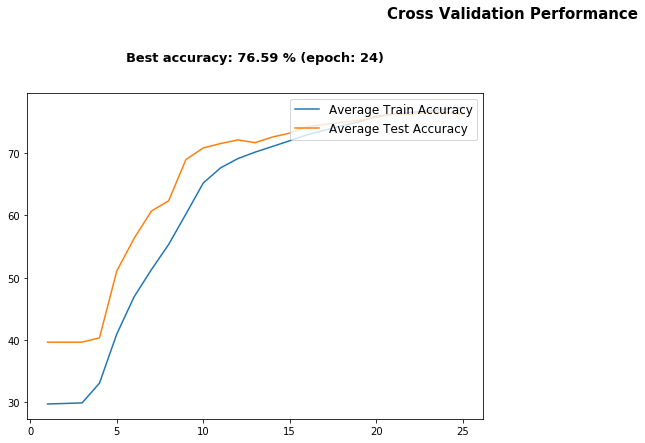

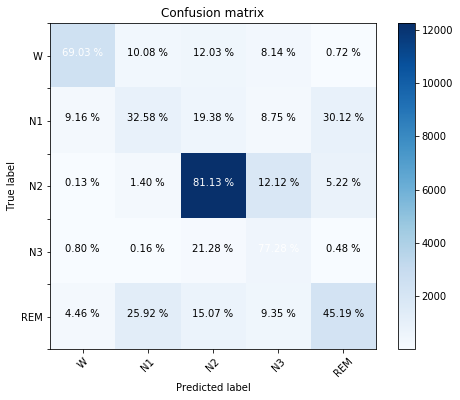

Acc  W 69.03 %
Acc  N1 32.58 %
Acc  N2 81.13 %
Acc  N3 77.28 %
Acc  REM 45.19 %


In [18]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

# 2. Conv1D

In [ ]:
class ConvSimple(nn.Module):

    def __init__(self):
        super(ConvSimple, self).__init__()
        self.n_classes = 5
        self.conv1 = nn.Conv1d(1, 32, kernel_size=10, padding=1, stride=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=10, padding=1, stride=3)
        self.pool1 = nn.AvgPool1d(2, stride=6)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool1d(2, stride=2)

        self.conv5 = nn.Conv1d(64, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.pool_avg = nn.AvgPool1d(2)

        self.linear1 = nn.Linear(3328, 128)

        self.dropout1 = nn.Dropout(0.02)

        # LL2:   128  -->  classes
        self.linear2 = nn.Linear(128, self.n_classes)

    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout1(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool_avg(x)
        x = self.dropout1(x)

        x = x.reshape(x.size(0), x.size(1) * x.size(2))
        # print(x.shape)  # 24'064

        x = self.linear1(x)
        x = F.relu(x)

        # Droput
        x = self.dropout1(x)

        # LL2:   128  -->  classes
        x = self.linear2(x)

        return x

In [ ]:
def run_experiment_cross_validation_CNN():
    MyNNutils = NN_Utils(learning_rate, batch_size, num_epochs)
    train_history_over_CV = []
    val_history_over_CV = []
    confusion_matrix_train_CV = []
    confusion_matrix_test_CV = []

    print('num_folds: ', num_folds, ' num_epochs: ', num_epochs)


    for fold_id in range(0, num_folds):
        # Loading Data
        X_train, y_train, X_test, y_test = prep_train_validate_data_CV(data_dir_eeg, fold_id, batch_size)

        if fold_id == 0:
            print('Train Data Shape: ', X_train.shape, '  Test Data Shape: ', X_test.shape)
            print('\n')

        char2numY = dict(zip(classes, range(len(classes))))
        for cl in classes:
            print("__Train ", cl, len(np.where(y_train == char2numY[cl])[0]), " => ",
                  len(np.where(y_test == char2numY[cl])[0]))

        print("\nFold <" + str(fold_id + 1) + ">")

        # model #
        net = ConvSimple()
        if fold_id == 0:
            display_num_param(net)
        net = net.to(device)

        train_history, validation_history, confusion_matrix_train_list, confusion_matrix_test_list = MyNNutils.train_model_cnn(net, X_train, y_train, X_test, y_test, device)
        
        # accumulate history for each CV loop, then take average
        train_history_over_CV.append(train_history)
        val_history_over_CV.append(validation_history)
        confusion_matrix_train_CV.append(confusion_matrix_train_list)
        confusion_matrix_test_CV.append(confusion_matrix_test_list)

        del net

    print(train_history_over_CV)
    print(val_history_over_CV)

    confusion_matrix_test_CV_final = confusion_matrix_test_CV[0]
    for i in range(1, num_folds):
        confusion_matrix_test_CV_final += confusion_matrix_test_CV[i]

    best_epoch_id = np.argmax(np.asarray(np.matrix(val_history_over_CV).mean(0)).reshape(-1))

    confusion_matrix_test_best = confusion_matrix_test_CV_final[best_epoch_id]
        
    return train_history_over_CV, val_history_over_CV, confusion_matrix_test_best

    

In [ ]:
num_epochs = 30
batch_size = 128
learning_rate = 0.001

train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation_CNN()
torch.save(confusion_matrix, 'conf_Conv1D.pt')
np.savez("train_Conv1D", train_history_over_CV)
np.savez("val_Conv1D", val_history_over_CV)

In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

# 3. ConvLSTM

In [ ]:
class ConvLSTM(nn.Module):

    def __init__(self, bi_dir):
        super(ConvLSTM, self).__init__()
        self.n_classes = 5
        self.hidden_dim = 256
        self.bi_dir = bi_dir

        # Conv
        self.conv1 = nn.Conv1d(1, 32, kernel_size=10, padding=1, stride=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=10, padding=1, stride=3)
        self.pool1 = nn.MaxPool1d(2, stride=6)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2, stride=2)


        self.linear1 = nn.Linear(1728, 128)

        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.7)


        # LSTM
        self.lstm_in_dim = 128
        self.lstm = nn.LSTM(self.lstm_in_dim, self.hidden_dim, bidirectional=self.bi_dir)

        # linear
        self.hidden2label1 = nn.Linear(self.hidden_dim * (1 + int(self.bi_dir)), self.n_classes)

    def forward(self, x, h_init, c_init):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout1(x)

        x = x.reshape(x.size(0), x.size(1) * x.size(2))
        # print(x.shape)  # 24'064

        x = self.linear1(x)
        x = F.relu(x)

        # Droput
        x = self.dropout1(x)



        cnn_x = F.relu(x)
        # print('cnn_x', cnn_x.shape)
        # LSTM
        g_seq = cnn_x.unsqueeze(dim=1)
        # print('g_seq', g_seq.shape)

        lstm_out, (h_final, c_final) = self.lstm(g_seq, (h_init, c_init))

        # Droput
        lstm_out = self.dropout2(lstm_out)

        # linear
        cnn_lstm_out = self.hidden2label1(lstm_out)  # activations are implicit

        # output
        scores = cnn_lstm_out

        return scores, h_final, c_final

In [ ]:
def run_experiment_cross_validation_ConvLSTM():
    MyNNutils = NN_Utils(learning_rate, batch_size, num_epochs)
    train_history_over_CV = []
    val_history_over_CV = []
    confusion_matrix_train_CV = []
    confusion_matrix_test_CV = []

    print('num_folds: ', num_folds, ' num_epochs: ', num_epochs)


    for fold_id in range(0, num_folds):
        # Loading Data
        X_train, y_train, X_test, y_test = prep_train_validate_data_CV(data_dir_eeg, fold_id, batch_size)

        if fold_id == 0:
            print('Train Data Shape: ', X_train.shape, '  Test Data Shape: ', X_test.shape)
            print('\n')

        char2numY = dict(zip(classes, range(len(classes))))
        for cl in classes:
            print("__Train ", cl, len(np.where(y_train == char2numY[cl])[0]), " => ",
                  len(np.where(y_test == char2numY[cl])[0]))

        print("\nFold <" + str(fold_id + 1) + ">")

        # model #
        bi_dir = False
        net = ConvLSTM(bi_dir)
        if fold_id == 0:
            display_num_param(net)
        net = net.to(device)

        train_history, validation_history, confusion_matrix_train_list, \
            confusion_matrix_test_list = MyNNutils.train_model_conv_lstm(net, X_train, y_train, X_test, y_test, bi_dir, device)
        
        # accumulate history for each CV loop, then take average
        train_history_over_CV.append(train_history)
        val_history_over_CV.append(validation_history)
        confusion_matrix_train_CV.append(confusion_matrix_train_list)
        confusion_matrix_test_CV.append(confusion_matrix_test_list)

        del net

    print(train_history_over_CV)
    print(val_history_over_CV)

    confusion_matrix_test_CV_final = confusion_matrix_test_CV[0]
    for i in range(1, num_folds):
        confusion_matrix_test_CV_final += confusion_matrix_test_CV[i]

    best_epoch_id = np.argmax(np.asarray(np.matrix(val_history_over_CV).mean(0)).reshape(-1))

    confusion_matrix_test_best = confusion_matrix_test_CV_final[best_epoch_id]
        
    return train_history_over_CV, val_history_over_CV, confusion_matrix_test_best

    

In [ ]:
num_epochs = 30
batch_size = 64
learning_rate = 0.04

train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation_ConvLSTM()
torch.save(confusion_matrix, 'conf_ConvLSTM.pt')
np.savez("train_ConvLSTM", train_history_over_CV)
np.savez("val_ConvLSTM", val_history_over_CV)

num_folds:  20  num_epochs:  30
Train Data Shape:  (56256, 1, 3000)   Test Data Shape:  (2112, 1, 3000)


__Train  W 9851  =>  283
__Train  N1 9854  =>  152
__Train  N2 16845  =>  921
__Train  N3 9857  =>  300
__Train  REM 9849  =>  456

Fold <1>
There are 647045 (0.65 million) parameters in this neural network
Epoch [1/30] , Accuracy :  29.808375995449378
Test Accuracy: 43.60795454545455 %


Epoch [2/30] , Accuracy :  29.94347269624573
Test Accuracy: 43.60795454545455 %


Epoch [3/30] , Accuracy :  29.94347269624573
Test Accuracy: 43.60795454545455 %


Epoch [4/30] , Accuracy :  29.961248577929467
Test Accuracy: 46.259469696969695 %


Epoch [5/30] , Accuracy :  37.71686575654152
Test Accuracy: 37.16856060606061 %


Epoch [6/30] , Accuracy :  41.67022184300341
Test Accuracy: 46.496212121212125 %


Epoch [7/30] , Accuracy :  49.232081911262796
Test Accuracy: 61.83712121212122 %


Epoch [8/30] , Accuracy :  53.757821387940844
Test Accuracy: 65.86174242424242 %


Epoch [9/30] , Accuracy :

In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

In [ ]:
# train_history_over_CV = np.load('train_MLP.npz')
# val_history_over_CV = np.load('val_MLP.npz')
# confusion_matrix = torch.load('conf_MLP.pt')
# plot_CV_history(train_history_over_CV['arr_0'], val_history_over_CV['arr_0'])
